In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

In [ ]:
import os

data_dir = './animefacedataset'
print(os.listdir(data_dir))

In [ ]:
print(len(os.listdir(data_dir + '/images')))

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = ((0.5,0.5,0.5),(0.5,0.5,0.5))

In [ ]:
train_ds = ImageFolder(data_dir,T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

In [ ]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(images):
  return images*stats[1][0]+stats[0][0]

In [ ]:
def show_images(images,nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images).detach()[:nmax],nrow=8).permute(1,2,0))

def show_batch(batch,nmax=64):
  for img,_ in batch:
    show_images(img,nmax=64)
    break

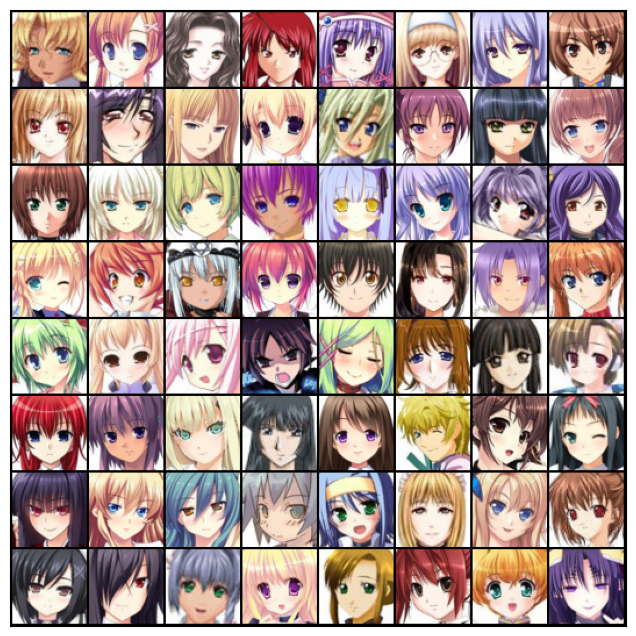

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # 3x64x64
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    # 64x32x32
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    #
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

    nn.Flatten(),
    nn.Sigmoid()

)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 256

In [ ]:
generator = nn.Sequential(

  nn.ConvTranspose2d(latent_size,512,kernel_size=4, stride=1, padding=0, bias=False),
  nn.BatchNorm2d(512),
  nn.ReLU(True),

  nn.ConvTranspose2d(512,256,kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(256),
  nn.ReLU(True),


  nn.ConvTranspose2d(256,128,kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(True),

  nn.ConvTranspose2d(128,64,kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(True),

  nn.ConvTranspose2d(64,3,kernel_size=4, stride=2, padding=1, bias=False),
  nn.Tanh()

)

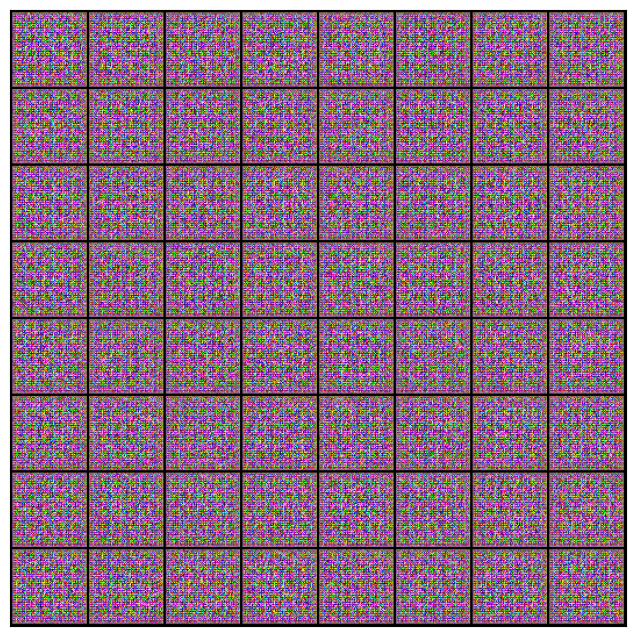

In [ ]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_images = generator(xb)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
from tqdm.notebook import tqdm # this module just displays a progress bar for training
import torch.nn.functional as F

In [ ]:
def discriminator_training(real_images,opt_d):

  opt_d.zero_grad()

  # passing real images
  real_preds = discriminator(real_images)
  # print("Real preds size:",real_preds)
  real_targets = torch.ones(real_images.size(0),1,device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # generating fake images
  latent = torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images = generator(latent)

  # passing fake images
  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0),1,device=device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # update grads
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(),real_score,fake_score

In [ ]:
def generator_training(opt_g):
  opt_g.zero_grad()

  # generating fake images
  latent = torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images = generator(latent)

  # predicting it
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1,device=device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


Saving generated-images-0000.png


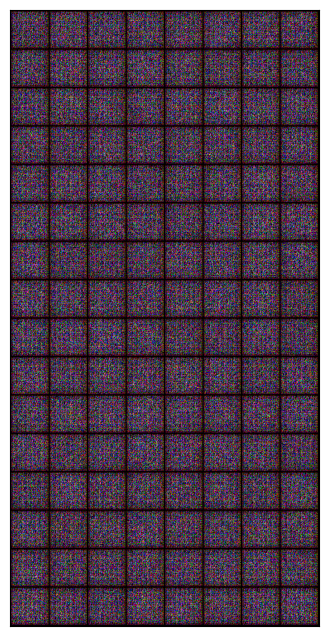

In [ ]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1,device=device)
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs,lr,start_idx=1):
  # logging everything
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
      for real_images,_ in tqdm(train_dl):
        loss_d,real_score,fake_score = discriminator_training(real_images,opt_d)
        loss_g = generator_training(opt_g)

      # Record losses & scores
      losses_g.append(loss_g)
      losses_d.append(loss_d)
      real_scores.append(real_score)
      fake_scores.append(fake_score)

      # Log losses & scores (last batch)
      print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

      # Save generated images
      save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
# !nvidia-smi

In [ ]:
# from torchvision import models
# from torchsummary import summary

# model = discriminator
# summary(discriminator, (3, 64, 64))

In [ ]:
history = fit(epochs, lr)

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

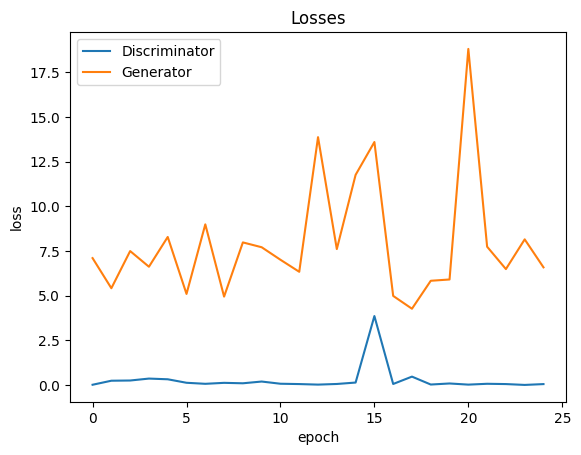

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

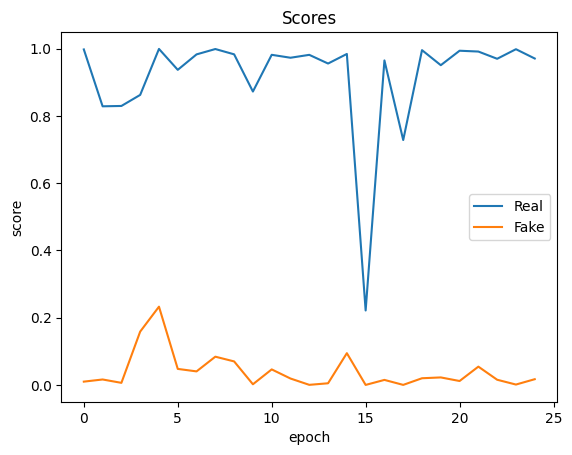

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');